# Process 'Company Role Title' Question Using a LLM

A generic version of the pipeline to be re-used for different types of questions.

Andrew Weng, 1/1/2025

We are going to use a mixed LLM-Python approach to solve the problem of "user text categorization."

This problem can be decomposed into five steps:

1. Pre-process (LLM1)
 - Each user provides up to three keywords as a string. These keywords need to be normalized and stored in a large list of individual keywords for the next stage.
2. Define categories (LLM2)
 - With the list of keywords, find the best set of categories to describe the keywords
3. Assign categories (LLM3)
 - For each keyword, assign it to a category. Be careful about how to handle exceptions (e.g., a keyword that doesn't seem to belog into any particular category.)
4. Count occurences (Python)
 - Within each category, sum up the total number of keywords. 
5. Visualize the results (Python)

In [3]:
import os
import time

current_folder = os.path.basename(os.getcwd())
if current_folder == 'notebooks':
    root_path = os.path.dirname(os.path.abspath(''))
    os.chdir(root_path)

from src.analyst import Analyst
from src.plotter import Plotter
from src.llm import LLM

from collections import defaultdict

import pickle
from pprint import pprint

from IPython import get_ipython
# Automatically reload all modules every time a line of code is executed
get_ipython().run_line_magic('load_ext', 'autoreload')
get_ipython().run_line_magic('autoreload', '2')

# Initialize our helper classes

In [4]:
analyst = Analyst()
analyst.load_data()
analyst.build_respondents_list()

plotter = Plotter()
llm = LLM()

# Fetch the relevant dataset to analyze

In [36]:
question = dict()
question['tag'] = 'company_role_title'
question['question'] = "What is your current job title?"
question['categories'] = [
 'Executive Leadership / Founders',
 'Directors / Senior Management',
 'Battery Engineers',
 'Electrochemical / Materials Scientists',
 'Mechanical Engineers',
 'Electrical / Electronics Engineers',
 'Software / Data / Algorithm Engineers',
 'Test / Validation Engineers',
 'Process / Manufacturing Engineers',
 'Quality Assurance / Control',
 'Supply Chain / Procurement / Logistics',
 'Sales / Business Development / Marketing',
 'Consultants / Advisors / Principals',
 'Professors / Educators / Academic Researchers',
 'Operations / Production Managers',
 'Safety / EHS Managers',
 'Human Resources / Talent Acquisition',
 'Application Engineers',
 'Project / Program Managers',
 'Electrode / Cell Engineers',
 'BMS / Battery Management Systems Engineers',
 'Battery Modeling / Simulation Engineers',
 'Energy Market Specialists',
 'Test Technicians / Lab Support',
 'Supply Chain / Procurement',
 'Marketing / Communications',
 'Senior / Staff / Principal Engineers',
 'Research Engineers / Staff Scientists']
question['data'] = analyst.summarize_company_role()['role_title_list']

In [7]:
question['data']

['Manager, R&D',
 'Design for Reliability',
 'Manager',
 'battery design release engineer',
 'Senior Battery Engineer',
 'Production Team Member',
 'post doctoral research associate',
 'Principal Engineer',
 'Asst. General Manager',
 'Research assistant',
 'Manager, Strategy and Corporate Development',
 'Content Manager',
 'Operations Supervisor',
 'Sales Director',
 'Engineering Consultant',
 'Associate Scientist',
 'Development Engineer',
 'BATTERY FIELD SYSTEMS ENGINEER',
 'Manager Consultant',
 'Principal Engineer',
 'Director',
 'Business development manager',
 'Electrolyte Scientist',
 'Senior Engineer',
 'Chief Technology Officer',
 'Director',
 'Staff Engineer',
 'Scientist',
 'Engineer',
 'Senior engineer',
 'System engineer',
 'Business development',
 'Algorithms engineer',
 'Commercial',
 'Director of R&D',
 'Senior Scientist',
 'Senior Application Engineer',
 'sales engineer',
 'Senior Engineer',
 'industrial engineer',
 'Senior Material Engineer',
 'Business Development',


# Pre-process the user response

Interpret the delimiters

In [8]:
# If only a single keyword is expected then skip this step

keyword_list = question['data']

# Define categories

In [37]:
if question['categories'] == []:

    categories = llm.define_categories(question['question'], keyword_list,
                                   num_categories=50)

    category_list = []
    for category in categories['categories']:
        category_list.append(category['name'])
else:
    category_list = question['categories']

pprint(category_list)

['Executive Leadership / Founders',
 'Directors / Senior Management',
 'Battery Engineers',
 'Electrochemical / Materials Scientists',
 'Mechanical Engineers',
 'Electrical / Electronics Engineers',
 'Software / Data / Algorithm Engineers',
 'Test / Validation Engineers',
 'Process / Manufacturing Engineers',
 'Quality Assurance / Control',
 'Supply Chain / Procurement / Logistics',
 'Sales / Business Development / Marketing',
 'Consultants / Advisors / Principals',
 'Professors / Educators / Academic Researchers',
 'Operations / Production Managers',
 'Safety / EHS Managers',
 'Human Resources / Talent Acquisition',
 'Application Engineers',
 'Project / Program Managers',
 'Electrode / Cell Engineers',
 'BMS / Battery Management Systems Engineers',
 'Battery Modeling / Simulation Engineers',
 'Energy Market Specialists',
 'Test Technicians / Lab Support',
 'Supply Chain / Procurement',
 'Marketing / Communications',
 'Senior / Staff / Principal Engineers',
 'Research Engineers / Staff

# Assign categories

Process one keyword at a time!

In [38]:
content_list = []
other_list = []
fail_list = []

for i, keyword in enumerate(keyword_list):

    print(f"Processing response: '{keyword}' ({i+1} of {len(keyword_list)})...")

    try:
        output = llm.classify_user_response(category_list, keyword,
                                            model='gpt-4o-mini')
    except: # JSON output fails
        fail_list.append(keyword)
        continue

    if output['result']['category'] in category_list:
        content_list.append(output)
    else:
        other_list.append(output)

Processing response: 'Manager, R&D' (1 of 603)...
Processing response: 'Design for Reliability' (2 of 603)...
Processing response: 'Manager' (3 of 603)...
Processing response: 'battery design release engineer' (4 of 603)...
Processing response: 'Senior Battery Engineer' (5 of 603)...
Processing response: 'Production Team Member' (6 of 603)...
Processing response: 'post doctoral research associate' (7 of 603)...
Processing response: 'Principal Engineer' (8 of 603)...
Processing response: 'Asst. General Manager' (9 of 603)...
Processing response: 'Research assistant' (10 of 603)...
Processing response: 'Manager, Strategy and Corporate Development' (11 of 603)...
Processing response: 'Content Manager' (12 of 603)...
Processing response: 'Operations Supervisor' (13 of 603)...
Processing response: 'Sales Director' (14 of 603)...
Processing response: 'Engineering Consultant' (15 of 603)...
Processing response: 'Associate Scientist' (16 of 603)...
Processing response: 'Development Engineer' (

In [39]:
print(len(other_list))

47


In [40]:
other_list

[{'result': {'response_text': 'Development Engineer', 'category': 'Other'}},
 {'result': {'response_text': 'Scientist', 'category': 'Other'}},
 {'result': {'response_text': 'Engineer', 'category': 'Other'}},
 {'result': {'response_text': 'System engineer', 'category': 'Other'}},
 {'result': {'response_text': 'Manager', 'category': 'Other'}},
 {'result': {'response_text': 'Engineer', 'category': 'Other'}},
 {'result': {'response_text': 'Smts', 'category': 'Other'}},
 {'result': {'response_text': 'MD', 'category': 'Other'}},
 {'result': {'response_text': 'Assistant Manager', 'category': 'Other'}},
 {'result': {'response_text': 'Engineer', 'category': 'Other'}},
 {'result': {'response_text': 'ASSISTANT ENGINEER DESIGN',
   'category': 'Other'}},
 {'result': {'response_text': 'technical expert', 'category': 'Other'}},
 {'result': {'response_text': 'Development Engineer', 'category': 'Other'}},
 {'result': {'response_text': 'Development Engineer', 'category': 'Other'}},
 {'result': {'respon

In [41]:
print(len(fail_list))

0


## Assembly dictionary for plotting and a 'collection' dictionary

The 'collection' is a reference for which keywords got sorted into which categories.

In [42]:

collection = defaultdict(list)
counter    = defaultdict(int)

for content in content_list:

    category = content['result']['category']
    response = content['result']['response_text']
    counter[category] += 1
    collection[category].append(response)

counter['_tot_'] = len(question['data'])
counter

defaultdict(int,
            {'Directors / Senior Management': 50,
             'Quality Assurance / Control': 7,
             'Operations / Production Managers': 18,
             'Electrode / Cell Engineers': 13,
             'Senior / Staff / Principal Engineers': 45,
             'Professors / Educators / Academic Researchers': 42,
             'Executive Leadership / Founders': 63,
             'Marketing / Communications': 3,
             'Sales / Business Development / Marketing': 72,
             'Consultants / Advisors / Principals': 24,
             'Research Engineers / Staff Scientists': 25,
             'BMS / Battery Management Systems Engineers': 6,
             'Electrochemical / Materials Scientists': 30,
             'Software / Data / Algorithm Engineers': 13,
             'Application Engineers': 9,
             'Process / Manufacturing Engineers': 22,
             'Energy Market Specialists': 2,
             'Project / Program Managers': 36,
             'Test / Val

In [43]:
collection

defaultdict(list,
            {'Directors / Senior Management': ['Manager, R&D',
              'Director',
              'Director',
              'Director of R&D',
              'Engineering Manager',
              'Director of Member Success',
              'Senior ATE System Technical Manager',
              'Director of Research',
              'Sr. Director of R&D',
              'Engineering Manager',
              'R&D Manager',
              'Director of Product Management',
              'Director, Product Management',
              'Head of Costing',
              'Director of Engineering',
              'Construction director',
              'Skills director',
              'Techonlogy Manager',
              'Sales Operations Director',
              'Director',
              'Sr. Engineering Manager',
              'Education and Training Director',
              'Director of Technology',
              'Senior Manager, R&D',
              'Technology Planning Manager',
  

# Visualize the results

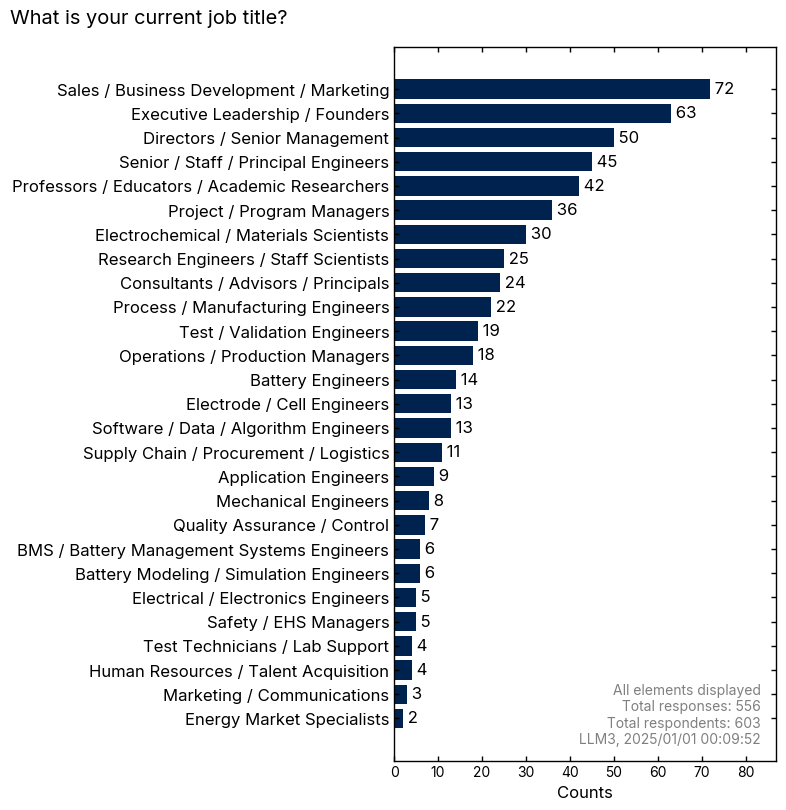

In [44]:
plotter.make_bar_plot_from_dict(counter,
                                title=question['question'],
                                sorted=True,
                                annotation=f'LLM3, {time.strftime("%Y/%m/%d %H:%M:%S")}',
                                num_elements=100,
                                saveas=f'{question['tag']}_{time.strftime("%Y%m%d_%H%M%S")}.png'
)